## Ensembling With StackNet

![](https://github.com/kaz-Anova/StackNet/raw/master/images/StackNet_Logo.png?raw=true)

In this kernel we will take a look on how to use StackNet to stack multiple levels of models in order to efficiently blend models. StackNet is a powerful package that works really well for competitions! We are going to stack a random forest on top of 3 GBM models as an example. We will use data from the [IEEE Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) competition to explain StackNet.

StackNet was created by Kaggle Grandmaster Marios Michailidis ([kazanova](https://www.kaggle.com/kazanova)) as part of his PhD. Thanks to [Kiran Kunapuli](https://www.kaggle.com/kirankunapuli) for uploading the package as [a Kaggle dataset](https://www.kaggle.com/kirankunapuli/pystacknet) so it can conveniently be used with Kaggle kernels.

Let's dive in!

## Table Of Contents

- [Dependencies](#1)
- [Metric (AUC)](#2)
- [Data Preparation](#3)
- [Modeling](#4)
- [Evaluation](#5)
- [Submission](#6)

## Dependencies <a id="1"></a>

In [1]:
# Import PyStackNet Package
# Source: https://www.kaggle.com/kirankunapuli/pystacknet
import os
import sys
sys.path.append("../input/pystacknet/repository/h2oai-pystacknet-af571e0")
import pystacknet

In [2]:
# Standard Dependencies
import gc
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# Machine Learning
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Specify paths and key features
KAGGLE_DIR = '../input/ieee-fraud-detection/'
TARGET = 'isFraud'

# Seed for reproducability
seed = 1234
np.random.seed(seed)

# For keeping time. Limit for Kaggle kernels is set to approx. 9 hours.
t_start = time.time()

In [3]:
# File sizes and specifications
print('\n# Files and file sizes:')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))


# Files and file sizes:
sample_submission.csv         | 6.08 MB
test_identity.csv             | 25.8 MB
train_transaction.csv         | 683.35 MB
test_transaction.csv          | 613.19 MB
train_identity.csv            | 26.53 MB


## Metric (AUC) <a id="2"></a>

The Metric used in this competition is "[Area Under ROC Curve (AUC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)". We create this curve by plotting the true positive rate (TPR) against the false positive rate (FPR) at different threshold settings. 
This is very convenient since with binary classification problems like fraud detection the accuracy score is not that informative. For example, if we predict only 0 (not fraud) on this dataset, then we will get an accuracy score of 0.965. The AUC score will be 0.5 (no better than random). All naive baselines will get an AUC score of approximately 0.5.

To calculate the AUC score we can use [sklearn's roc_auc_score function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) straight out of the box.

Image: An example of an ROC curve. AOC is a typo and should be AUC.

![](https://miro.medium.com/max/722/1*pk05QGzoWhCgRiiFbz-oKQ.png)

In [4]:
def auc_score(y_true, y_pred):
    """
    Calculates the Area Under ROC Curve (AUC)
    """
    return roc_auc_score(y_true, y_pred)

To plot the ROC curve we will use a function using sklearn and matplotlib. An example of this visualization is shown in the evaluation section of this kernel.

In [5]:
def plot_curve(y_true_train, y_pred_train, y_true_val, y_pred_val, model_name):
    """
    Plots the ROC Curve given predictions and labels
    """
    fpr_train, tpr_train, _ = roc_curve(y_true_train, y_pred_train, pos_label=1)
    fpr_val, tpr_val, _ = roc_curve(y_true_val, y_pred_val, pos_label=1)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, color='black',
             lw=2, label=f"ROC train curve (AUC = {round(roc_auc_score(y_true_train, y_pred_train), 4)})")
    plt.plot(fpr_val, tpr_val, color='darkorange',
             lw=2, label=f"ROC validation curve (AUC = {round(roc_auc_score(y_true_val, y_pred_val), 4)})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'ROC Plot for {model_name}', weight="bold", fontsize=20)
    plt.legend(loc="lower right", fontsize=16)

## Data Preparation <a id="3"></a>

Since this kernel is meant to explain StackNet and establish a baseline we will not go into advanced feature engineering and EDA here. However, your performance will greatly benefit from feature engineering so I encourage you to explore it. A good kernel which does that for this competition can be found [here](https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again?scriptVersionId=18874747).

In [6]:
# Load in datasets
train_transaction = pd.read_csv(f"{KAGGLE_DIR}train_transaction.csv", index_col='TransactionID')
test_transaction = pd.read_csv(f"{KAGGLE_DIR}test_transaction.csv", index_col='TransactionID')
train_identity = pd.read_csv(f"{KAGGLE_DIR}train_identity.csv", index_col='TransactionID')
test_identity = pd.read_csv(f"{KAGGLE_DIR}test_identity.csv", index_col='TransactionID')

# Merge datasets into full training and test dataframe
train_df = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True).reset_index()
test_df = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True).reset_index()
del train_identity, train_transaction, test_identity, test_transaction
gc.collect()

105

In [7]:
# Select only first 52 features
# The other columns are quite noisy
train_df = train_df.iloc[:, :53]
test_df = test_df.iloc[:, :52]

StackNet does not accept missing values (NaN's), Infinity values (inf) or values higher than 32 bytes (for example float64 or int64). Therefore, we have to fill in missing values and compress certain columns as the Pandas standard is 64 bytes. Big thanks to [Arjan Groen](https://www.kaggle.com/arjanso) for creating this convenient function. The function is taken from [this Kaggle kernel](https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65).

In [8]:
def reduce_mem_usage(df):
    """
    Reduces memory usage for all columns in a Pandas DataFrame
    """
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings                       
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int32)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    else:
                        df[col] = df[col].astype(np.uint32)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    else:
                        df[col] = df[col].astype(np.int32)
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    # Print final result
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is after reduction is:",mem_usg," MB")
    return df, NAlist

In [9]:
# Reduce memory
train_df, _ = reduce_mem_usage(train_df)
test_df, _ = reduce_mem_usage(test_df)

Memory usage of properties dataframe is : 238.78964233398438  MB
Memory usage of properties dataframe is after reduction is: 102.49939727783203  MB
Memory usage of properties dataframe is : 201.01889038085938  MB
Memory usage of properties dataframe is after reduction is: 87.94583320617676  MB


In [10]:
# Drop nuisance columns and specify target variable
X_train = train_df.drop([TARGET, 'TransactionID', 'TransactionDT'], axis=1)
X_test = test_df.drop(['TransactionID', 'TransactionDT'], axis=1)
target = train_df[TARGET]

# Label Encoding
lbl = LabelEncoder()
for f in X_train.columns:
    if X_train[f].dtype == 'object': 
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

In [11]:
# Split Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  target,
                                                  test_size=0.15, 
                                                  random_state=seed, 
                                                  stratify=target)

## Modeling <a id="4"></a>

StackNet allows you to define all kinds of models. For example, Sklearn models, LightGBM, XGBoost, CatBoost and Keras models can all be used with StackNet.

For the individual models, you are responsible for not overfitting. Therefore, it is advisable to first experiment with individual models and make sure they are sound, before combining them into StackNet. For this example we will use [sklearn's Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), a [LightGBM Regressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor) and a [CatBoost Regressor](https://catboost.ai/docs/concepts/python-reference_catboostregressor.html) in the 1st level. Then we will train a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) in level 2, which takes the predictions of the models in the 1st level as input. StackNet takes care of the stacking and cross validation.

In [12]:
# Level 1 are the base models that take the training dataset as input
l1_clf1 = GradientBoostingRegressor(n_estimators=400,
                                    learning_rate=0.006,
                                    min_samples_leaf=10,
                                    max_depth=15, 
                                    max_features='sqrt', 
                                    subsample=0.85,
                                    random_state=seed)

l1_clf2 = LGBMRegressor(boosting_type='gbdt',
                        objective="binary",
                        metric="AUC",
                        boost_from_average="false",
                        learning_rate=0.0045,
                        num_leaves=491,
                        max_depth=20,
                        min_child_weight=0.035,
                        feature_fraction=0.38,
                        bagging_fraction=0.42,
                        min_data_in_leaf=100,
                        max_bin=255,
                        importance_type='split',
                        reg_alpha=0.4,
                        reg_lambda=0.65,
                        bagging_seed=seed,
                        random_state=seed,
                        verbosity=-1,
                        subsample=0.85,
                        colsample_bytree=0.8,
                        min_child_samples=79)

l1_clf3 = CatBoostRegressor(learning_rate=0.2,
                            bagging_temperature=0.1, 
                            l2_leaf_reg=30,
                            depth=12, 
                            max_bin=255,
                            iterations=100,
                            loss_function='Logloss',
                            objective='RMSE',
                            eval_metric="AUC",
                            bootstrap_type='Bayesian',
                            random_seed=seed,
                            early_stopping_rounds=10)

# Level 2 models will take predictions from level 1 models as input
# Remember to keep level 2 models smaller
# Basic models like Ridge Regression with large regularization or small random forests work well
l2_clf1 = RandomForestRegressor(n_estimators=250, 
                                max_depth=5, 
                                max_features='sqrt', 
                                random_state=seed)

The model tree that StackNet takes as input is a list of lists. The 1st list defines the 1st level, the 2nd one the 2nd level, etc. You can build a model tree of arbitrary depth and width.

In [13]:
# Specify model tree for StackNet
models = [[l1_clf1, l1_clf2, l1_clf3], # Level 1
          [l2_clf1]] # Level 2

The model is compiled and fitted through the a familiar sklearn-like API. The StackNetClassifier will perform cross-validation (CV) and will output the CV scores for each model. To make sure we can output a probability of fraud we specify "use_proba=True".

The "folds" argument in StackNetClassifier can also accept an iterable of train/test splits. Since the target distibution is imbalanced you can probably improve on the CV strategy by first yielding stratified train/test split with for example [sklearn's StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

In [14]:
from pystacknet.pystacknet import StackNetClassifier

# Specify parameters for stacked model and begin training
model = StackNetClassifier(models, 
                           metric="auc", 
                           folds=3,
                           restacking=False,
                           use_retraining=True,
                           use_proba=True, # To use predict_proba after training
                           random_state=seed,
                           n_jobs=-1, 
                           verbose=1)

# Fit the entire model tree
model.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


====================== Start of Level 0 ======================
Input Dimensionality 50 at Level 0 
3 models included in Level 0 
Fold 1/3 , model 0 , auc===0.936141 
Fold 1/3 , model 1 , auc===0.885430 
Fold 1/3 , model 2 , auc===0.916928 
=========== end of fold 1 in level 0 ===========
Fold 2/3 , model 0 , auc===0.934705 
Fold 2/3 , model 1 , auc===0.889733 
Fold 2/3 , model 2 , auc===0.917682 
=========== end of fold 2 in level 0 ===========
Fold 3/3 , model 0 , auc===0.937759 
Fold 3/3 , model 1 , auc===0.887843 
Fold 3/3 , model 2 , auc===0.920002 
=========== end of fold 3 in level 0 ===========
Output dimensionality of level 0 is 3 
====================== End of Level 0 ======================
 level 0 lasted 16553.498105 seconds 
====================== Start of Level 1 ======================
Input Dimensionality 3 at Level 1 
1 models included in Level 1 
Fold 1/3 , model 0 , auc===0.927901 
=========== end of fold 1 in level 1 ===========
Fold 2/3 , model 0 , auc===0.927658 
==

In [15]:
# Get score on training set and validation set for our StackNetClassifier
train_preds = model.predict_proba(X_train)[:, 1]
val_preds = model.predict_proba(X_val)[:, 1]
train_score = auc_score(y_train, train_preds)
val_score = auc_score(y_val, val_preds)

====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 
====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 


In [16]:
print(f"StackNet AUC on training set: {round(train_score, 4)}")
print(f"StackNet AUC on validation set: {round(val_score, 4)}")

StackNet AUC on training set: 0.9578
StackNet AUC on validation set: 0.9325


## Evaluation <a id="5"></a>

The blue line signifies the baseline AUC which is 0.5. The final validation score is the area under the orange curve, which is mentioned in the plot.

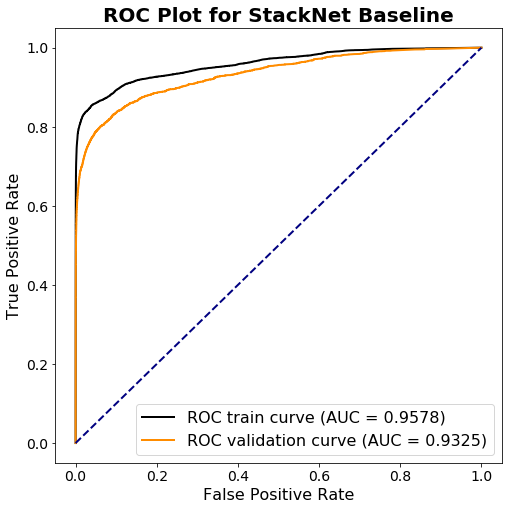

In [17]:
# Plot ROC curve
plot_curve(y_train, train_preds, y_val, val_preds, "StackNet Baseline")

## Submission <a id="6"></a>

In [18]:
# Write predictions to csv
sub = pd.read_csv(f"{KAGGLE_DIR}sample_submission.csv")
preds = model.predict_proba(X_test)[:, 1]
sub[TARGET] = preds
sub.to_csv(f"submission.csv", index=False)

====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

To check if the predictions are sound, we check the format of our submission and compare our prediction distribution with that of the target distribution in the training set.

In [19]:
# Check Submission format
print("Final Submission Format:")
sub.head()

Final Submission Format:


,TransactionID,isFraud
0,3663549,0.034215
1,3663550,0.080067
2,3663551,0.032016
3,3663552,0.037355
4,3663553,0.028835


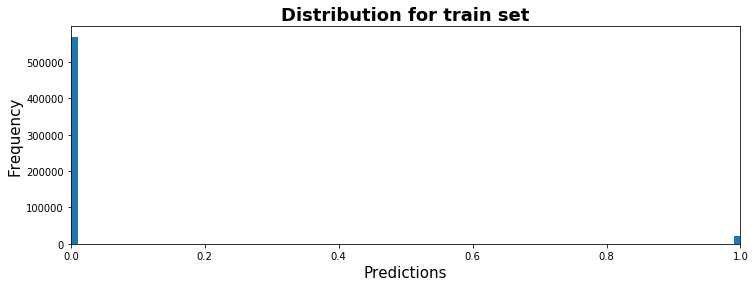

In [20]:
plt.figure(figsize=(12,4))
plt.hist(train_df[TARGET], bins=100)
plt.title("Distribution for train set", weight='bold', fontsize=18)
plt.xlabel("Predictions", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim(0, 1);

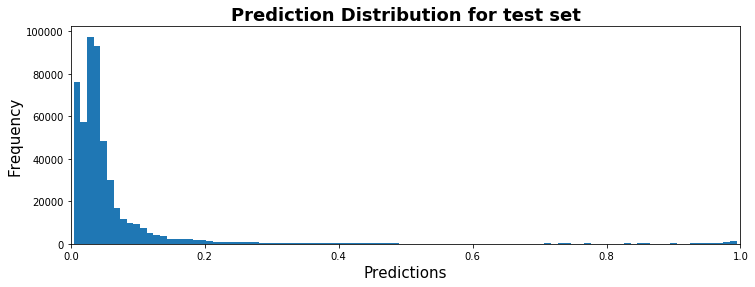

In [21]:
plt.figure(figsize=(12,4))
plt.hist(sub[TARGET], bins=100)
plt.title("Prediction Distribution for test set", weight='bold', fontsize=18)
plt.xlabel("Predictions", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim(0, 1);

In [22]:
# Check kernels run-time. Limit for Kaggle Kernels is set to approx. 9 hours.
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, 
                                                      int(total_time*60)))

Kernel runtime = 4.7049 hours (282 minutes)


Try to experiment with [StackNet](https://github.com/h2oai/pystacknet) yourself. The possibilities are almost endless!

If you want to check out another solution using PyStackNet, check out [this Kaggle kernel on the Titanic dataset by Yann Berthelot](https://www.kaggle.com/yannberthelot/pystacknet-working-implementation).

**If you like this Kaggle kernel, feel free to give an upvote and leave a comment! I will try to implement your suggestions in this kernel!**